In [1]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Choose set

#### Select subs who are constant in their study 1 cluster

In [3]:
model = 'MP_ppSOE'
study = 1
clusters_4 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-4_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
clusters_6 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-6_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),index_col=None,header=None).T)[0]
clusters = clusters_4.merge(clusters_6,on='sub')
clusters = clusters.loc[~clusters['sub'].isin(exclude)]
clusters.columns = ['sub','x4','x6']
clusters['stable'] = 1*(clusters['x4']==clusters['x6'])
clusters.head()
clusters = clusters[['sub','x4','stable']]
clusters.columns = ['sub','cluster','stable']
clusters_study2 = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
                'ParamsClusters_study-2_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']]
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study2/HMTG/exclude.csv'),index_col=0,header=0).T)[0]
clusters_study2 = clusters_study2.loc[~clusters_study2['sub'].isin(exclude)]
clusters_study2.columns = ['sub','cluster']
clusters_study2['stable'] = 1
clusters = clusters.append(clusters_study2)
clusters.head()

,sub,cluster,stable
0,1,MO,1
1,2,GR,1
2,3,MO,0
3,4,IA,1
4,5,IA,1


In [18]:
print(clusters.query('sub < 150')['stable'].sum())
print(clusters.query('sub > 150')['stable'].sum())
print(clusters['stable'].sum())

74
55
129


#### Load self-reported strategy

In [6]:
strat_1 = pd.read_csv(os.path.join(base_dir,
            'Data/Study%i/SelfReportStrategy/parsed.csv'%1),index_col=0)
strat_1['sub'] = strat_1['record']-110000
strat_1.replace(to_replace=np.nan,value=0,inplace=True)
strat_1.head()
strat_2 = pd.read_csv(os.path.join(base_dir,
            'Data/Study%i/SelfReportStrategy/parsed.csv'%2),index_col=0)
strat_2.head()
strat_2.replace(to_replace=np.nan,value=0,inplace=True)
strat_2_map = pd.read_csv(os.path.join(base_dir,'Data/Study2/SubCastorMap.csv'),index_col=None,header=None)
strat_2_map.columns = ['sub','record']
strat_2['record'] = strat_2['record'].astype(int)
strat_2 = strat_2.merge(strat_2_map,on='record')
strat_2.head()

strat_both = strat_1.append(strat_2)
strat_both = strat_both[['sub','GR','IA','GA','Altruism','AdvantEquity','DoubleInv','MoralOpport','Reciprocity','Return10','ReturnInv','RiskAssess','SplitEndow']]
strat_both.replace(to_replace=np.nan,value=0,inplace=True)
strat_both.head()

### Merge with clustering and additional measures
strat_use = strat_both.merge(clusters,on='sub')
strat_use = strat_use.loc[(strat_use['stable']==1)]
strat_use.head()
print (strat_use.shape)

/Users/jeroen/anaconda3/envs/hmtg_fu/lib/python3.8/site-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


(129, 15)


## Plot

In [7]:
strategyList = ['GR','IA','GA','Altruism','AdvantEquity','DoubleInv','MoralOpport',
                'Reciprocity','Return10','ReturnInv','RiskAssess','SplitEndow']
allStrategies_melted = strat_use.melt(id_vars=['sub','cluster'],value_vars=strategyList,
                                          var_name='Strategy',value_name='Weight')
allStrategies_melted.head()

,sub,cluster,Strategy,Weight
0,1,MO,GR,40.0
1,2,GR,GR,100.0
2,4,IA,GR,2.5
3,5,IA,GR,5.0
4,8,MO,GR,15.0


IA: F = 33.49, p = 0.0000
GR: F = 52.51, p = 0.0000
GA: F = 13.63, p = 0.0000


/Users/jeroen/anaconda3/envs/hmtg_fu/lib/python3.8/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


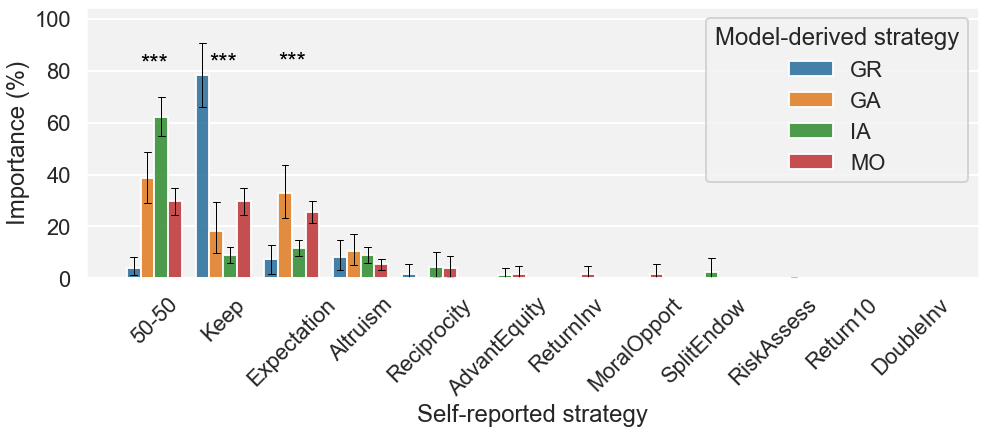

In [8]:
FigureTools.mydesign(context='poster')
sns.set_palette('tab10',len(strategyList))
strategyListOrder = [list(strategyList).index(list(strat_use.iloc[:,1:-2].mean().sort_values(
    ascending=False).index)[i]) for i in range(len(strategyList))]
strategyListOrdered = [strategyList[i] for i in strategyListOrder]
fig,ax = plt.subplots(1,1,figsize=[16,5])
sns.barplot(data=allStrategies_melted,x='Strategy',y='Weight',ax=ax,
           errwidth = 1, capsize = 0.1,errcolor='k',alpha=.9,
            hue='cluster',hue_order=['GR','GA','IA','MO'],
            order = strategyListOrdered,
           )
strategyListOrdered_renamed = list(['50-50','Keep','Expectation'])+strategyListOrdered[3:]
plt.xticks(range(len(strategyList)),strategyListOrdered_renamed,rotation=45);
for i,strat in enumerate(strategyListOrdered):
    allImp = allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat),'Weight']
    stats = scipy.stats.f_oneway(
        allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']=='GR'),'Weight'],
        allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']=='GA'),'Weight'],
        allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']=='IA'),'Weight'],
        allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']=='MO'),'Weight'])
    if stats[1] < 0.05:
        FigureTools.add_sig_markers(ax,relationships=[[i-.2,i+.2,stats[1]]],linewidth=0,ystart=70)
        print ('%s: F = %.2f, p = %.4f'%(strat,stats[0],stats[1]))
plt.xlabel('Self-reported strategy')
plt.ylabel('Importance (%)')
plt.legend(title='Model-derived strategy')

In [9]:
groups = ['GR','GA','IA','MO']
pairs = [[0,1],[0,2],[0,3],[1,2],[2,3],[1,3]]
for strat in ['IA','GA','GR']:
    print (strat)
    stratResults = pd.DataFrame(columns=['group1','group2','t','df','p'])
    for pair in pairs:
        group1 = groups[pair[0]]
        group2 = groups[pair[1]]
        samp1 = allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']==group1),'Weight']
        samp2 = allStrategies_melted.loc[(allStrategies_melted['Strategy']==strat) & 
                                 (allStrategies_melted['cluster']==group2),'Weight']
        df = len(samp1) + len(samp2) -1
        stats = scipy.stats.ttest_ind(samp1,samp2)
#         print '%s vs %s: t(%i) = %.2f, p = %.4f, p-corr = %.4f'%(
#             group1,group2,df,stats[0],stats[1],stats[1]*len(pairs))
        stratResults = stratResults.append(pd.DataFrame([[group1,group2,df,stats[0],stats[1]]],
                                                        columns=stratResults.columns))
    stratResults = stratResults.sort_values(by='p',ascending=False)
    stratResults['p_holm'] = np.multiply(np.array(stratResults['p']),np.arange(1,7))
    print (stratResults)

IA
  group1 group2   t        df             p        p_holm
0     GA     MO  73  1.542849  1.272515e-01  1.272515e-01
0     GA     IA  53 -3.094441  3.171295e-03  6.342590e-03
0     GR     MO  74 -5.042293  3.238856e-06  9.716569e-06
0     GR     GA  30 -6.146267  1.067144e-06  4.268575e-06
0     IA     MO  97  6.961503  4.161373e-10  2.080686e-09
0     GR     IA  54 -8.614668  1.181892e-11  7.091355e-11
GA
  group1 group2   t        df         p    p_holm
0     GR     IA  54 -1.327026  0.190189  0.190189
0     GA     MO  73  1.403849  0.164662  0.329325
0     GR     GA  30 -3.926371  0.000488  0.001465
0     GR     MO  74 -4.120314  0.000099  0.000395
0     GA     IA  53  4.707956  0.000019  0.000095
0     IA     MO  97 -4.699145  0.000009  0.000052
GR
  group1 group2   t         df             p        p_holm
0     GA     MO  73  -1.932614  5.721764e-02  5.721764e-02
0     GA     IA  53   2.224236  3.049888e-02  6.099776e-02
0     GR     GA  30   7.082825  8.594400e-08  2.578320e-07

In [7]:
savedat = allStrategies_melted.loc[allStrategies_melted['Strategy'].isin(['IA','GA','GR','Altruism'])].reset_index(drop=True)
savedat.to_csv(base_dir+'/Data/Pooled/SelfReportStrategies/SelfReportStrategies2.csv')

## Plot by group in 3-strat space

In [19]:
stratsInclude = ['GR', 'IA', 'GA']
dat = allStrategies_melted.loc[allStrategies_melted['Strategy'].isin(stratsInclude)]
dat.head()

,sub,cluster,Strategy,Weight
0,1,MO,GR,40.0
1,2,GR,GR,100.0
2,4,IA,GR,2.5
3,5,IA,GR,5.0
4,8,MO,GR,15.0


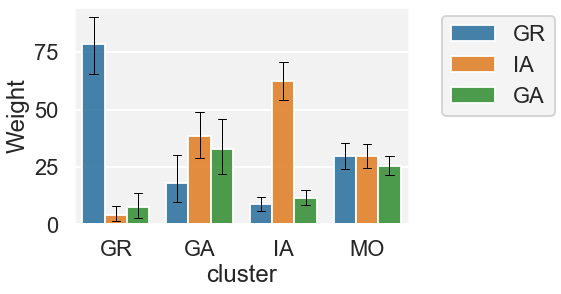

In [20]:
sns.barplot(data=dat,x='cluster',y='Weight',
            errwidth = 1, capsize = 0.1,errcolor='k',alpha=.9,
            hue='Strategy',hue_order=stratsInclude,
            order = ['GR','GA','IA','MO'],
           )
plt.legend(loc=[1.1,.5])
# plt.legend(['Keep','50-50','Expectation','Altruism'])

In [21]:
dat_piv = dat.pivot_table(index=['sub','cluster'],columns='Strategy',values='Weight').reset_index()
dat_piv.head()

Strategy,sub,cluster,GA,GR,IA
0,1,MO,20.0,40.0,40.0
1,2,GR,0.0,100.0,0.0
2,4,IA,10.0,2.5,80.0
3,5,IA,10.0,5.0,85.0
4,8,MO,25.0,15.0,60.0


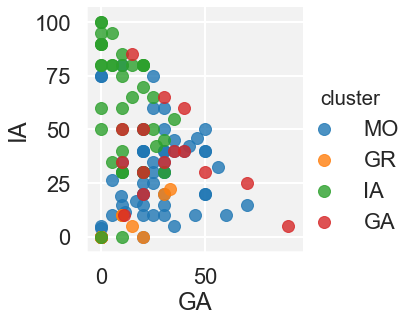

In [22]:
sns.lmplot(data=dat_piv,x='GA',y='IA',hue='cluster',fit_reg=False)

GR
GA
IA
MO
GR
GA
IA
MO
GR
GA
IA
MO


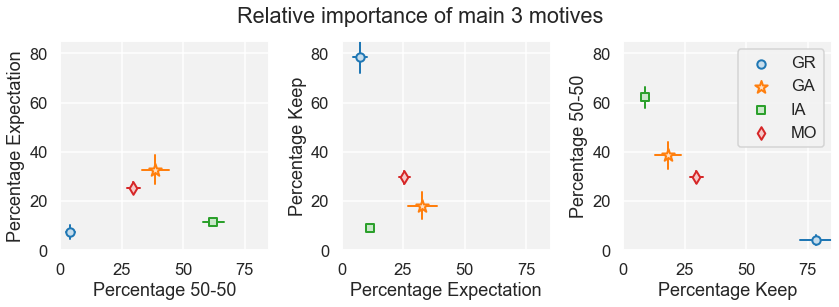

In [23]:
FigureTools.mydesign()
sns.set_context('talk')
colors = sns.color_palette('tab10',4)
markers = ['o','*','s','d']
sizes = [70,170,60,80]
clusters = ['GR','GA','IA','MO']
fig,ax = plt.subplots(1,3,figsize=[12,4])
axisContents = [['IA','GA'],['GA','GR'],['GR','IA']]
faceWhiteFactor = 3
faceColors = colors
for i in range(faceWhiteFactor):
    faceColors = np.add(faceColors,np.tile([1,1,1],[4,1]))
faceColors = faceColors/(faceWhiteFactor+1)
stratTranslate = dict(zip(['IA','GA','GR'],['50-50','Expectation','Keep']))
for i in range(3):
    points = []
    axCur = ax[i]
    for clustInd,clust in enumerate(clusters):
        print (clust)
        x_point = dat_piv.loc[dat_piv['cluster']==clust,axisContents[i][0]].mean()
        y_point = dat_piv.loc[dat_piv['cluster']==clust,axisContents[i][1]].mean()
        handle = axCur.scatter(x_point,y_point, alpha=1,zorder=10, linewidth=2, edgecolor=colors[clustInd],
                               c=[faceColors[clustInd]], s=sizes[clustInd], marker=markers[clustInd])
        points.append(handle)
        x_sterr = scipy.stats.sem(dat_piv.loc[dat_piv['cluster']==clust,axisContents[i][0]])
        y_sterr = scipy.stats.sem(dat_piv.loc[dat_piv['cluster']==clust,axisContents[i][1]])
        x_range = [x_point - x_sterr, x_point + x_sterr]
        y_range = [y_point - y_sterr, y_point + y_sterr]
        axCur.plot(x_range,[y_point,y_point],c=colors[clustInd],linewidth=2,zorder=1)#,alpha=.5)
        axCur.plot([x_point,x_point],y_range,c=colors[clustInd],linewidth=2,zorder=1)#,alpha=.5)
    axCur.set(xlabel = 'Percentage %s'%stratTranslate[axisContents[i][0]],
              ylabel = 'Percentage %s'%stratTranslate[axisContents[i][1]])
ax[2].legend(points,clusters)#,loc=[1.1,.5])
for i in range(3):
    ax[i].set(xlim = [0,85], ylim = [0,85], aspect=1)
plt.tight_layout()
plt.suptitle('Relative importance of main 3 motives',y=1.05)
plt.show()
# FigureTools.mysavefig(fig,'Motives')

##### Set up 3d plot

In [33]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
FigureTools.mydesign()
sns.set_style('darkgrid', {"axes.facecolor": "1"})
sns.set_context('paper')
colors = sns.color_palette('tab10',4)
markers = ['o','*','s','d']
sizes = [70,170,60,80]
clusters = ['GR','GA','IA','MO']
faceWhiteFactor = 3
faceColors = colors
for i in range(faceWhiteFactor):
    faceColors = np.add(faceColors,np.tile([1,1,1],[4,1]))
faceColors = faceColors/(faceWhiteFactor+1)
stratTranslate = dict(zip(['IA','GA','GR'],['50-50','Expectation','Keep']))

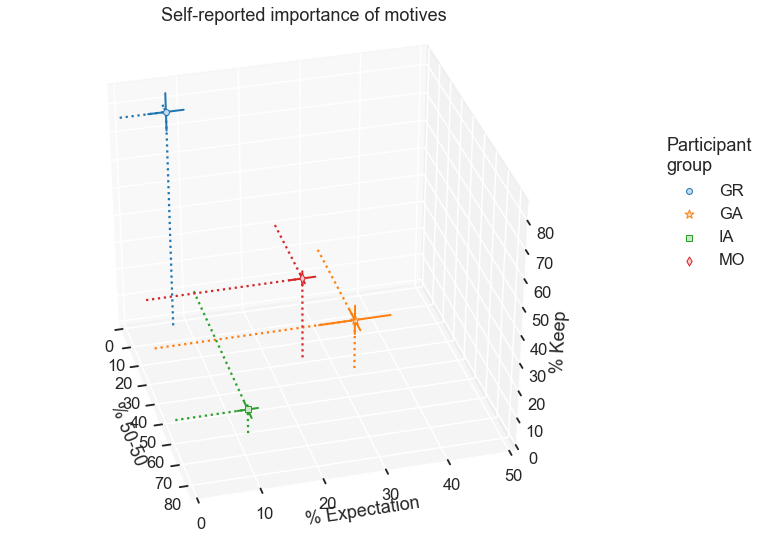

In [41]:
fig = plt.figure(figsize = [11,8])
ax = fig.add_subplot(111, projection='3d')
sns.set_context('talk')

points = []
for clustInd,clust in enumerate(clusters):
    dat = dat_piv.query('cluster == @clust')
    means = dat[['IA','GA','GR']].mean().values
    sterrs = scipy.stats.sem(dat[['IA','GA','GR']])
    handle = ax.scatter(*means, linewidth=1, edgecolor=colors[clustInd],
                           c=[faceColors[clustInd]], s=sizes[clustInd]/2, marker=markers[clustInd])
    points.append(handle)
    ax.plot([0,means[0]],[means[1],means[1]],[means[2],means[2]],':',color=colors[clustInd])
    ax.plot([means[0],means[0]],[0,means[1]],[means[2],means[2]],':',color=colors[clustInd])
    ax.plot([means[0],means[0]],[means[1],means[1]],[0,means[2]],':',color=colors[clustInd])
    
    ax.plot([means[0] - sterrs[0],means[0] + sterrs[0]], [means[1],means[1]], [means[2],means[2]],
            c=colors[clustInd],linewidth=2,zorder=1)
    ax.plot([means[0],means[0]], [means[1] - sterrs[1],means[1] + sterrs[1]], [means[2],means[2]],
            c=colors[clustInd],linewidth=2,zorder=1)
    ax.plot([means[0],means[0]], [means[1],means[1]], [means[2] - sterrs[2],means[2] + sterrs[2]],
            c=colors[clustInd],linewidth=2,zorder=1)
ax.set(xlabel = '%% %s'%stratTranslate['IA'],
       ylabel = '%% %s'%stratTranslate['GA'],
       zlabel = '%% %s'%stratTranslate['GR'])
ax.legend(points,clusters, title = 'Participant\ngroup', loc = [1.1,.5], frameon=False)
ax.set(xlim = [0,85], ylim = [0,50], zlim = [0,85])
plt.title('Self-reported importance of motives',y=1.05)
plt.tight_layout()
ax.view_init(elev=35,azim=-15) # Or azim -110
plt.savefig(base_dir + '/Results/Figure6.pdf',bbox_inches='tight')